In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import random
from scipy import fftpack

In [2]:
procedure = ['Healthy', 'COLPOs','LEEPs']
results_folders=[]

for folder_name in procedure:
    main_path = 'R:\\Cervical_Project\\Data\\' + folder_name
    os.chdir(main_path)
    files = os.listdir()
    for file in files:
        new_path = os.path.join(main_path, file)
        print(new_path)
        if os.path.isdir(new_path) and 'results_final' in os.listdir(new_path):
            paired_path = os.path.join(new_path, 'results_final')
            results_folders.append(paired_path)

R:\Cervical_Project\Data\Healthy\20191003_Hysterectomy
R:\Cervical_Project\Data\Healthy\20191031_Hysterectomy
R:\Cervical_Project\Data\Healthy\20191107_Hysterectomy
R:\Cervical_Project\Data\Healthy\20191121_Hysterectomy
R:\Cervical_Project\Data\Healthy\20200220_Hysterectomy
R:\Cervical_Project\Data\Healthy\20200305_Hysterectomy
R:\Cervical_Project\Data\Healthy\20200928_Hysterectomy
R:\Cervical_Project\Data\Healthy\20201008_Hysterectomy
R:\Cervical_Project\Data\Healthy\20201119_Hysterectomy
R:\Cervical_Project\Data\Healthy\20201127_Hysterectomy
R:\Cervical_Project\Data\Healthy\20201214_Hysterectomy
R:\Cervical_Project\Data\Healthy\20210218_Hysterectomy
R:\Cervical_Project\Data\Healthy\20210415_Hysterectomy
R:\Cervical_Project\Data\Healthy\20210423_Hysterectomy
R:\Cervical_Project\Data\Healthy\20210526_Hysterectomy
R:\Cervical_Project\Data\Healthy\20210715_Hysterectomy
R:\Cervical_Project\Data\Healthy\20211104_Hysterectomy
R:\Cervical_Project\Data\Healthy\20220331_Hysterectomy
R:\Cervica

In [3]:
results_folders

['R:\\Cervical_Project\\Data\\Healthy\\20191003_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20191031_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20191107_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20191121_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20200220_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20200305_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20200928_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20201008_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20201119_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20201127_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20201214_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20210218_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20210415_Hysterectomy\\re

In [5]:
def normalize(image, p_min=2, p_max=99.9, dtype='float32'):
    '''
    Normalizes the image intensity so that the `p_min`-th and the `p_max`-th
    percentiles are converted to 0 and 1 respectively.
    References
    ----------
    Content-Aware Image Restoration: Pushing the Limits of Fluorescence
    Microscopy
    https://doi.org/10.1038/s41592-018-0216-7
    '''
    low, high = np.percentile(image, (p_min, p_max))
    return (image - low) / (high - low + 1e-6)

def patch_image(image):
    '''Image should be 512x512'''
    return image.reshape(2, 256, 2, 256).swapaxes(1, 2).reshape(4, 256, 256)

def stitch_image(image):
    '''Image should be 4x256x256'''
    return np.reshape(image,[2, -1, 256, 256]).swapaxes(1,2).reshape(512, 512)

def create_patches(input,start,end,flag):
    start = int(start)
    end = int(end)
    indices = list(range(start,end+1))
    total_patches = []
    for i in indices:
        image = input[i]
        image = np.transpose(image)
        image = normalize(image,2,99.9)
        if flag == 1:
            image += LFG(512,512,0)
        patches = patch_image(image)
        total_patches.append(patches)
    total_patches = np.reshape(total_patches,(-1,256,256))
    return list(total_patches)

def Patchify(f,roi_name):
    try: 
        start_stack = f['stack_begin'][0]-1
        end_stack = f['stack_end'][0]-1
        FAD= f['FAD_frames_512_shifted']
        NADH= f['NADH_frames_512_shifted']
        stack_num = end_stack - start_stack + 1
        assert stack_num > 0
        low_SNR_NADH = create_patches(np.mean(NADH, axis=0),start_stack,end_stack,1)
        high_SNR_NADH = create_patches(np.mean(NADH, axis=0),start_stack,end_stack,0)
        low_SNR_FAD = create_patches(np.mean(FAD, axis=0),start_stack,end_stack,1)
        high_SNR_FAD = create_patches(np.mean(FAD, axis=0),start_stack,end_stack,0)
        print('Start and end found: ' + roi_name + ": images=" + str(stack_num))
        return low_SNR_NADH , high_SNR_NADH, low_SNR_FAD, high_SNR_FAD, stack_num
    except:
        print('Data was not processed: ' + roi_name)
        return [],[],[],[],[]
        
def LFG(dim1, dim2, seed=0):
    random.seed(seed)
    # Generate a high frequency image of noise
    hf = np.random.rand(dim1,dim2)
    # Calculate Spectrum
    hf_S = fftpack.fft2(hf)
    # Filter Spectrum
    nx = round(0.05*dim1)
    ny = round(0.05*dim2)
    hf_S[nx-1:dim1-nx-1, :] = 0
    hf_S[:, ny-1:dim2-ny-1] = 0
    # Revert back to low frequency and return
    return np.real(fftpack.ifft2(hf_S))


In [6]:
size=512
X_N = []
X_F = []
Y_N = []
Y_F = []
start_list = []
end_list = []
key_names = []
ROI_counter = 0
stack_count = 0
for result_folder in results_folders:
    roi_mats = []
    os.chdir(result_folder)
    experiment_files = os.listdir()
    for experiment_file in experiment_files:
        if experiment_file.endswith('FINAL.mat'):
            roi_mats.append(experiment_file)
    for roi in roi_mats:
        roi_name = roi[0:-4]
        f= h5py.File(roi)
        low_SNR_NADH , high_SNR_NADH, low_SNR_FAD, high_SNR_FAD, stack_num = Patchify(f,roi_name)
        if len(low_SNR_NADH) > 0:
            key_names.append(roi_name)
            X_N.append(low_SNR_NADH)
            Y_N.append(high_SNR_NADH)
            X_F.append(low_SNR_FAD)
            Y_F.append(high_SNR_FAD)
            ROI_counter += 1
            start_list.append(int(stack_count*4))
            stack_count += stack_num 
            end_list.append(int(stack_count*4-1))
print('done')

Data was not processed: 20191003_Hysterectomy_ROI1_Series019_Series020_FINAL
Data was not processed: 20191003_Hysterectomy_ROI2_Series030_Series033_FINAL
Data was not processed: 20191003_Hysterectomy_ROI3_Series036_Series035_FINAL
Data was not processed: 20191031_Hysterectomy_ROI1_Series005_Series006_FINAL
Data was not processed: 20191031_Hysterectomy_ROI2_Series008_Series009_FINAL
Data was not processed: 20191031_Hysterectomy_ROI3_Series011_Series012_FINAL
Data was not processed: 20191031_Hysterectomy_ROI4_Series014_Series015_FINAL
Data was not processed: 20191031_Hysterectomy_ROI5_Series017_Series019_FINAL
Start and end found: 20191107_Hysterectomy_ROI1_FLIM 008_FLIM 2_016_FLIM 014_FLIM 2_022_FINAL: images=[40.]
Start and end found: 20191121_Hysterectomy_ROI1_Series004_Series005_FINAL: images=[25.]
Start and end found: 20191121_Hysterectomy_ROI2_Series012_Series014_FINAL: images=[33.]
Start and end found: 20191121_Hysterectomy_ROI3_Series021_Series022_FINAL: images=[29.]
Start and en

In [17]:
# Seed here is constant as we only ever want to generate ONE identical Training and Test Set
ROIs = ROI_counter
testing_split = round(ROIs*1/3)
random.seed(0) 
Training_idx = sorted(random.sample(range(0,ROIs), ROIs-testing_split))
Training_idx = [int(x) for x in Training_idx]
Testing_idx = sorted([x for x in list(range(0,ROIs)) if x not in Training_idx])

In [28]:
key_names = np.array(key_names)
start_list = np.array(start_list)
end_list = np.array(end_list)
X_N, X_F, Y_N, Y_F = np.array(X_N, dtype=object), np.array(X_F, dtype=object), np.array(Y_N, dtype=object), np.array(Y_F,dtype=object)

In [29]:
key_names_train = key_names[Training_idx]
start_list_train = start_list[Training_idx]
end_list_train = end_list[Training_idx]
X_N_train = X_N[Training_idx]
Y_N_train = Y_N[Training_idx]
X_F_train = X_F[Training_idx]
Y_F_train = Y_F[Training_idx]

key_names_test = key_names[Testing_idx]
start_list_test = start_list[Testing_idx]
end_list_test = end_list[Testing_idx]
X_N_test = X_N[Testing_idx]
Y_N_test= Y_N[Testing_idx]
X_F_test = X_F[Testing_idx]
Y_F_test = Y_F[Testing_idx]

In [30]:
# Training Set Saving
ROI_keys = [key[:(key.find('ROI')+4)] for key in key_names_train]
stack_begin = [item for item in start_list_train]
stack_end = [item for item in end_list_train]
X_n = [item for sublist in X_N_train for item in sublist]
Y_n = [item for sublist in Y_N_train for item in sublist]
X_f = [item for sublist in X_F_train for item in sublist]
Y_f = [item for sublist in Y_F_train for item in sublist]

In [49]:
np.savez('R:\\Cervical_Project\\Data\\NV_928_NADH_Training', X=X_n, Y=Y_n, SB=stack_begin, SE=stack_end, ROI_keys=ROI_keys)
np.savez('R:\\Cervical_Project\\Data\\NV_928_FAD_Training', X=X_f, Y=Y_f, SB=stack_begin, SE=stack_end, ROI_keys=ROI_keys)

In [31]:
# Testing Set Saving
ROI_keys = [key[:(key.find('ROI')+4)] for key in key_names_test]
stack_begin = [item for item in start_list_test]
stack_end = [item for item in end_list_test]
X_n = [item for sublist in X_N_test for item in sublist]
Y_n = [item for sublist in Y_N_test for item in sublist]
X_f = [item for sublist in X_F_test for item in sublist]
Y_f = [item for sublist in Y_F_test for item in sublist]

In [32]:
np.savez('R:\\Cervical_Project\\Data\\NV_LFN_NADH_Testing', X=X_n, Y=Y_n, SB=stack_begin, SE=stack_end, ROI_keys=ROI_keys)
np.savez('R:\\Cervical_Project\\Data\\NV_LFN_FAD_Testing', X=X_f, Y=Y_f, SB=stack_begin, SE=stack_end, ROI_keys=ROI_keys)

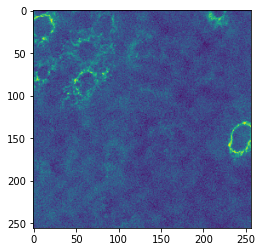

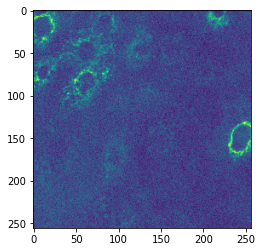

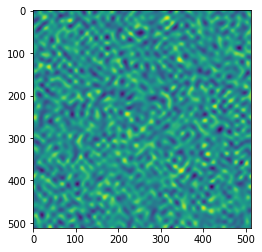

In [36]:
plt.imshow(X_n[0])
plt.figure()
plt.imshow(Y_n[0])
plt.figure()
plt.imshow(LFG(512,512,0))

In [33]:
# Test set ROI names:
for i in ROI_keys:
    print(i)

20191121_Hysterectomy_ROI3
20200220_Hyterectomy_ROI1
20200928_Hysterectomy_ROI2
20201119_Hysterectomy_ROI1
20201127_Hysterectomy_ROI2
20201127_Hysterectomy_ROI4
20201214_Hysterectomy_ROI1
20201214_Hysterectomy_ROI2
20201214_Hysterectomy_ROI3
20210415_Hysterectomy_ROI1
20210415_Hysterectomy_ROI3
20210526_Hysterectomy_ROI1
20210526_Hysterectomy_ROI3
20201211_COLPO_ROI1
20201211_COLPO_ROI2
20201211_COLPO_ROI3
20201221_COLPO_ROI1
20201221_COLPO_ROI5
20210108_COLPO_ROI4
20210312_COLPO_ROI1
20210402_COLPO_ROI2
20210402_COLPO_ROI3
20210409_COLPO_ROI1
20210525_COLPO_ROI1
20210816_COLPO_ROI1
20210921_COLPO_ROI1
20211008_COLPO_ROI1
20200901_LEEP_ROI3
20200902_LEEP_ROI2
20200909_LEEP_ROI4
20210126_LEEP_ROI1
20210126_LEEP_ROI2
20210330_LEEP_ROI1
20210519_LEEP_ROI1
20210604_LEEP_ROI2
20210604_LEEP_ROI3
20210810_LEEP_ROI1
20210810_LEEP_ROI2
20210910_LEEP_ROI1
20210929_LEEP_ROI1
20210929_LEEP_ROI2
20211022_LEEP_ROI2
20211108_LEEP_ROI2
20211116_LEEP_ROI3
20211217_LEEP_ROI1
20211228_LEEP_ROI1
20211228_